In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics 
from scipy import interpolate
from scipy import integrate
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

In [4]:
df = pd.read_csv('abroca_try.csv')

In [5]:
df.head(5)

,Release Year,County of Indictment,Gender,Age at Release,Return Status
0,2008,UNKNOWN,MALE,55,Not Returned
1,2008,ALBANY,MALE,16,Returned Parole Violation
2,2008,ALBANY,MALE,17,Not Returned
3,2008,ALBANY,MALE,17,Returned Parole Violation
4,2008,ALBANY,MALE,18,Not Returned


In [6]:
df['Return Status'].value_counts()

Not Returned                 72477
Returned Parole Violation    39730
New Felony Offense           11381
Name: Return Status, dtype: int64

In [7]:
df['returned'] = np.where(df['Return Status'] != "Not Returned",1,0)

In [8]:
df.head(4)

,Release Year,County of Indictment,Gender,Age at Release,Return Status,returned
0,2008,UNKNOWN,MALE,55,Not Returned,0
1,2008,ALBANY,MALE,16,Returned Parole Violation,1
2,2008,ALBANY,MALE,17,Not Returned,0
3,2008,ALBANY,MALE,17,Returned Parole Violation,1


In [9]:
df.dtypes

Release Year             int64
County of Indictment    object
Gender                  object
Age at Release           int64
Return Status           object
returned                 int64
dtype: object

In [11]:
le = preprocessing.LabelEncoder()

In [12]:
for i in df.columns:
    if df[i].dtypes == 'object':
        df[i] = le.fit_transform(df[i])

In [13]:
df.head(5)

,Release Year,County of Indictment,Gender,Age at Release,Return Status,returned
0,2008,56,1,55,1,0
1,2008,0,1,16,2,1
2,2008,0,1,17,1,0
3,2008,0,1,17,2,1
4,2008,0,1,18,1,0


In [14]:
X = df.iloc[:,0:4]

In [15]:
y = df.iloc[:,5:6]

In [16]:
y

,returned
0,0
1,1
2,0
3,1
4,0
...,...
123583,1
123584,1
123585,1
123586,1


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [19]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression()

In [20]:
X_test['pred_proba'] = lr.predict_proba(X_test)[:,:1]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [21]:
X_test['returned'] = y_test

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [22]:
df_test = X_test

In [23]:
df_test.head(4)

,Release Year,County of Indictment,Gender,Age at Release,pred_proba,returned
90035,2011,27,1,32,0.563569,0
39985,2009,30,1,34,0.574855,0
54660,2010,22,1,22,0.512355,0
505,2008,0,1,39,0.580429,0


In [27]:
def compute_roc(y_scores,y_true):
    fpr,tpr,_ = metrics.roc_curve(y_true, y_scores)
    return fpr,tpr

def compute_auc(y_scores,y_true):
    auc = metrics.roc_auc_score(y_true,y_scores)
    return auc

def interpolate_roc_fun(fpr,tpr,n_grid):
    roc_approx = interpolate.interp1d(x = fpr, y = tpr)
    x_new = np.linspace(0,1,num = n_grid)
    y_new = roc_approx(x_new)
    return x_new,y_new

In [39]:
def slice_plot(majority_roc_x, minority_roc_x,
               majority_roc_y, minority_roc_y, majority_group_name = 'baseline', minority_group_name = 'comparison', fout = './slice_plot.png'):
    plt.figure(1, figsize=(6,5))
    plt.title('ABROCA - Slice Plot')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(majority_roc_x, majority_roc_y, label = "{o} - Baseline".format(o=majority_group_name), linestyle='-', color='r')
    plt.plot(minority_roc_x, minority_roc_y, label = "{o} - Comparison".format(o=minority_group_name), linestyle='-', color='b')
    plt.fill(majority_roc_x.tolist()+np.flipud(minority_roc_x).tolist(), majority_roc_y.tolist()+np.flipud(minority_roc_y).tolist(),"y")
    plt.legend()
    plt.savefig(fout)
    plt.show()

In [24]:
if df_test['pred_proba'].between(0, 1,inclusive=True).any():
    continue
else:
    print('predictions must be in range [0,1]')
    exit(1)
if len(df_test.returned.value_counts) == 2:
    continue
else:
    print("The label column should be binary")
    exit(1)
    

SyntaxError: 'continue' not properly in loop (<ipython-input-24-73b8daf7fdac>, line 5)

In [25]:
# initialize data structures
slice_score = 0
prot_attr_values = df_test.Gender.value_counts().index.values
fpr_tpr_dict = {}

In [28]:
for pa_value in prot_attr_values:
    pa_df_test = df_test[df_test.Gender == pa_value]
    fpr_tpr_dict[pa_value] = compute_roc(pa_df_test['pred_proba'],pa_df_test['returned'])

In [29]:
majority_roc_x, majority_roc_y = interpolate_roc_fun(fpr_tpr_dict[1][0],fpr_tpr_dict[1][1],1000)
minority_roc_x, minority_roc_y = interpolate_roc_fun(fpr_tpr_dict[0][0],fpr_tpr_dict[0][1],1000)

In [30]:
if list(majority_roc_x) == list(minority_roc_x):
    f1 = interpolate.interp1d(x = majority_roc_x, y = (majority_roc_y-minority_roc_y))
    f2 = lambda x: abs(f1(x))
    slice, _ = integrate.quad(f2, 0, 1, limit = 1000)
else:
    print('error in majority and minortiy x values')
    exit(1)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


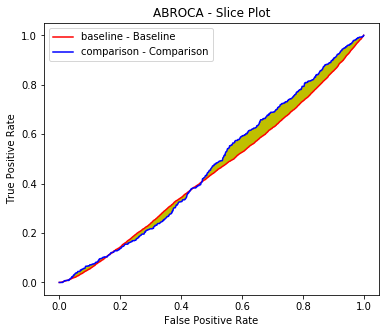

In [40]:
slice_plot(majority_roc_x, minority_roc_x,
               majority_roc_y, minority_roc_y)

In [34]:
slice

0.032383224888169845

In [44]:
from compute_abroca import compute_abroca

NameError: name 'TRUE' is not defined